In [1]:
import sys

import numpy as np
np.set_printoptions(linewidth=150)

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.optimize import curve_fit

In [2]:
from lattviz import draw_lattice_2d

In [3]:
# Fitting functions
def inverse_square(x, k):
    return k * np.power(x, -2)

def inverse_square_bg(x, k, y_0):
    return y_0 + k * np.power(x, -2)

def inverse_exp(x, k, b):
    return k * np.exp(-b*x)

def gaussian(x, A, b, c):
    return A * np.exp(-(x-b)**2/(2*c))

def mwbm(x, a, b):
    return (2/np.pi)**0.5 * (x+b)**2/a**3 * np.exp(-(x-b)**2/(2*a**2))

In [13]:
n = 2
NL = 16

cxs_unsorted = []
cys_unsorted = []
czs_unsorted = []

if n == 2:
    if NL == 8:
        idxs_dir     = [0, 4,  1,  5, 2,  6,  3,  7]
        cxs_unsorted = [1, 0, -1,  0, 1, -1, -1,  1]
        cys_unsorted = [0, 1,  0, -1, 1,  1, -1, -1]
        
        boundary_idxs_left = [2, 5, 6]
        boundary_idxs_right = [0, 4, 7]
        boundary_idxs_top = [1, 4, 5]
        boundary_idxs_bottom = [3, 6, 7]
    elif NL == 16:
        idxs_dir     = [0, 4,  1,  5, 2,  6,  3,  7, 8, 9, 10, 11, 12, 13, 14, 15]
        cxs_unsorted = [1, 0, -1,  0, 1, -1, -1,  1, 2, 1, -1, -2, -2, -1,  1,  2]
        cys_unsorted = [0, 1,  0, -1, 1,  1, -1, -1, 1, 2,  2,  1, -1, -2, -2, -1]
        # cxs_unsorted      = [3, 0, -3,  0, 2, -2, -2,  2, 3, 1, -1, -3, -3, -1,  1,  3]
        # cys_unsorted      = [0, 3,  0, -3, 2,  2, -2, -2, 1, 3,  3,  1, -1, -3, -3, -1]

        boundary_idxs_left = [2, 5, 6, 11, 12]
        boundary_idxs_right = [0, 4, 7, 8, 15]
        boundary_idxs_top = [1, 4, 5, 9, 10]
        boundary_idxs_bottom = [3, 6, 7, 13, 14]

    # boundary_pos = [
    #     [slice(0, NY, 1),    slice(0, 1, 1)    ], # left
    #     [slice(0, NY, 1),    slice(NX-1, NX, 1)], # right
    #     [slice(0, 1, 1),     slice(0, NX, 1)   ], # top
    #     [slice(NY-1, NY, 1), slice(0, NX, 1)   ], # bottom
    # ]
    
    boundary_idxs = [boundary_idxs_left, boundary_idxs_right, boundary_idxs_top, boundary_idxs_bottom]
elif n == 3:
    if NL == 18 or True:
        idxs_dir     = [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
        cxs_unsorted = [-1,  0,  0, -1, -1, -1, -1,  0,  0, 1,  0,  0,  1,  1,  1,  1,  0,  0]
        cys_unsorted = [ 0, -1,  0, -1,  1,  0,  0, -1, -1, 0,  1,  0,  1, -1,  0,  0,  1,  1]
        czs_unsorted = [ 0,  0, -1,  0,  0, -1,  1, -1,  1, 0,  0,  1,  0,  0,  1, -1,  1, -1]

assert len(cxs_unsorted) == NL
assert len(cys_unsorted) == NL

if n >= 3:
    assert len(czs_unsorted) == NL

cxs = cxs_unsorted
cys = cys_unsorted
czs = czs_unsorted
# cxs = [cxs_unsorted[i_dir] for i_dir in idxs_dir]
# cys = [cys_unsorted[i_dir] for i_dir in idxs_dir]

# for i in range(NL):
#     mag_c_i = (cxs[i]**2 + cys[i]**2)**0.5
#     cxs[i] /= mag_c_i
#     cys[i] /= mag_c_i

print(cxs)
print(cys)

print("-----")

[1, 0, -1, 0, 1, -1, -1, 1, 2, 1, -1, -2, -2, -1, 1, 2]
[0, 1, 0, -1, 1, 1, -1, -1, 1, 2, 2, 1, -1, -2, -2, -1]
-----


In [14]:
def emit(xf, sources):
    # Source boundary conditions
    for source_position, source_value in sources:
        if isinstance(source_value, list):
            if len(source_value) == xf.shape[2]:
                xf[source_position] = source_value
            else:
                raise ValueError(f"Source value list of length {len(source_value)}, instead of expected {xf.shape[2]}.")
        else:
            xf[source_position, :] = source_value
        
        # for dir_i, i_dir in enumerate(idxs_dir):
        #     nl = i_dir
        #     cy = cys[i_dir]
        #     cx = cxs[i_dir]
        #     xf[*source_position, nl] *= 3 * (cx**2+cy**2)/2**0.5

    return xf

# @TODO - generalize to 3D
def apply_boundary_conditions(xi, boundary_conditions="absorb"):
    xf = np.array(xi, copy=True)

    if boundary_conditions == "periodic":
        # leftwards radiation going to x-right from x-left
        xf[:, -1, boundary_idxs_left] = xi[:, 0, boundary_idxs_left]
        xf[:, 0, boundary_idxs_left] = 0
        # rightwards radiation going to x-left from x-right
        xf[:, 0, boundary_idxs_right] = xi[:, -1, boundary_idxs_right]
        xf[:, -1, boundary_idxs_right] = 0
        # upwards radiation going to y-bottom from y-top
        xf[0, :, boundary_idxs_top] = xi[-1, :, boundary_idxs_top]
        xf[-1, :, boundary_idxs_top] = 0
        # downwards radiation going to y-top from y-bottom
        xf[-1, :, boundary_idxs_bottom] = xi[0, :, boundary_idxs_bottom]
        xf[0, :, boundary_idxs_bottom] = 0
    elif boundary_conditions == "absorb":
        # x-left
        xf[:, 0, boundary_idxs_left] = xi[:, 1, boundary_idxs_left]
        # x-right
        xf[:, -1, boundary_idxs_right] = xi[:, -2, boundary_idxs_right]
        # y-top
        xf[0, :, boundary_idxs_top] = xi[1, :, boundary_idxs_top]
        # y-bottom
        xf[-1, :, boundary_idxs_bottom] = xi[-2, :, boundary_idxs_bottom]
    elif isinstance(boundary_conditions, list):
        if len(boundary_conditions != 4):
            raise ValueError("Please specify boundary condition for all boundaries when using custom boundary conditions!")
        
        for b, boundary_condition in enumerate(boundary_conditions):
            bc_type = boundary_condition[0]

            if bc_type == "dirichlet":
                bc_val = boundary_condition[1]
                
                if b == 0:
                    xf[:, 0, boundary_idxs_left] = bc_val
                elif b == 1:
                    xf[:, -1, boundary_idxs_right] = bc_val
                elif b == 2:
                    xf[0, :, boundary_idxs_top] = bc_val
                elif b == 3:
                    xf[-1, :, boundary_idxs_bottom] = bc_val
            elif bc_type == "neumann":
                bc_grad = boundary_condition[1]
                
                if b == 0:
                    xf[:, 0, boundary_idxs_left] = bc_grad * xi[:, 1, boundary_idxs_left]
                elif b == 1:
                    xf[:, -1, boundary_idxs_right] = bc_grad * xi[:, -2, boundary_idxs_right]
                elif b == 2:
                    xf[0, :, boundary_idxs_top] = bc_grad * xi[1, :, boundary_idxs_top]
                elif b == 3:
                    xf[-1, :, boundary_idxs_bottom] = bc_grad * xi[-2, :, boundary_idxs_bottom]
            elif bc_type == "periodic":
                if b == 0:
                    xf[:, 0, boundary_idxs_left] = xi[:, -1, boundary_idxs_left]
                elif b == 1:
                    xf[:, -1, boundary_idxs_right] = xi[:, 0, boundary_idxs_right]
                elif b == 2:
                    xf[0, :, boundary_idxs_top] = xi[-1, :, boundary_idxs_top]
                elif b == 3:
                    xf[-1, :, boundary_idxs_bottom] = xi[0, :, boundary_idxs_bottom]

    return xf
    

def propagate(xi, number_density, redist_coeff):
    NX = np.shape(xi)[1]
    NY = np.shape(xi)[0]
    
    # xf = np.array(xi, copy=True)
    xf = np.zeros_like(xi)

    for dir_i, i_dir in enumerate(idxs_dir):
        nl = i_dir
        cy = cys[i_dir]
        cx = cxs[i_dir]

        for j in range(NY):
            for i in range(NX):
                l_src = xi[j, i, nl]

                dir_i_next = (dir_i+1) % NL
                dir_i_prev = (dir_i-1) % NL
                nl_next = idxs_dir[dir_i_next]
                nl_prev = idxs_dir[dir_i_prev]

                cx_next = cxs[nl_next]
                cy_next = cys[nl_next]
                cx_prev = cxs[nl_prev]
                cy_prev = cys[nl_prev]

                # @TODO - adjust streamed amount based on speed
                l_stream = l_src
                if False:
                    v = (cx**2 + cy**2)**0.5/2**0.5
                    l_stream = l_src * v
                    xf[j, i, nl] += l_src - l_stream

                # calculate optical depth for main streaming
                dt = 1
                dr = np.sqrt(cx**2 + cy**2) * dt
                sigma = 1
                n = number_density
                tau = sigma * n * dr

                # stream the value to the next lattice in the same direction
                xf[(j + cy) % NY, (i + cx) % NX, nl] += redist_coeff * l_stream * np.exp(-tau)

                # if np.sum(l_src) > 0:
                #     print(f"lattice indices: {nl_prev} {nl} {nl_next}")
                #     print(f"lattice directions - (x,y) order: {cx_prev, cy_prev} {cx, cy} {cx_next, cy_next}")
                #     print(f"lattice directions - (y,x) order: {cy_prev, cx_prev} {cy, cx} {cy_next, cx_next}")
                #     print(f"this lattice point: {j, i}, {nl}")
                #     print(f"the carrier lattice dest: {(j + cy) % NY, (i + cx) % NX}, {nl}")
                #     print(f"the next lattice dest: {(j + cy_next) % NY, (i + cx_next) % NX}, {nl_next}")
                #     print(f"the prev lattice dest: {(j + cy_prev) % NY, (i + cx_prev) % NX}, {nl_prev}")
                #     print("this lattice has:", l_src)
                #     print("transferring the following amount to the carrier lattice dest:", redist_coeff * l_src, xf[(j + cy) % NY, (i + cx) % NX, nl])
                #     print("transferring amount to the next lattice dest:", (1-redist_coeff)/2 * l_src, xf[(j + cy_next) % NY, (i + cx_next) % NX, nl_next])
                #     print("transferring amount to the prev lattice dest:", (1-redist_coeff)/2 * l_src, xf[(j + cy_prev) % NY, (i + cx_prev) % NX, nl_prev])

                # redistribute the value to the next adjacent lattices in the adjacent directions
                # xf[(j + cy_next) % NY, (i + cx_next) % NX, nl_next] += (1-redist_coeff)/2 * l_stream
                # xf[(j + cy_prev) % NY, (i + cx_prev) % NX, nl_prev] += (1-redist_coeff)/2 * l_stream

                # redistribute the value to the next lattice in the adjacent directions
                xf[(j + cy) % NY, (i + cx) % NX, nl_next] += (1-redist_coeff)/2 * l_stream
                xf[(j + cy) % NY, (i + cx) % NX, nl_prev] += (1-redist_coeff)/2 * l_stream

                # if np.sum(l_src) > 0:
                #     xa = xf[(j + cy) % NY, (i + cx) % NX, nl]
                #     xb = xf[(j + cy_next) % NY, (i + cx_next) % NX, nl_next]
                #     xc = xf[(j + cy_prev) % NY, (i + cx_prev) % NX, nl_prev]
                #     print(f"final result: {xc}, {xa}, {xb}")

                # if np.sum(l_src) > 0:
                #     print("-----")

        # break

    # conserve total by decrementing the value at the source
    # xf -= xi
    
    # anomaly = np.sum(xf) - np.sum(xi)
    # if anomaly != 0.0:
    #     print("Total distribution not conserved!")
    #     # print(np.sum(xf[::-1, :], axis=2))
    #     print(anomaly)
    #     return None

    return xf

In [30]:
def simulate(
    x0,
    NX, NY,
    sources,
    number_density=0.0,
    redist_coeff=1.00,
    boundary_conditions="periodic",
    n_it=100,
    plotRealTime=False,
    plotLattViz=False,
    plot_period=10
):
    # initial setup
    if x0 is None:
        x0 = np.zeros(shape=(NY, NX, NL))

    # copy of array for simulation loop
    x_prev = np.array(x0, copy=True)

    # simulation loop
    for it in range(n_it):
        # print(f"=== iteration {it+1} ===")
    
        # copy the previous array
        x = np.array(x_prev, copy=True)
    
        # propagate - streaming w/ redistribution
        x = propagate(x, number_density, redist_coeff)
    
        # enforce boundary conditions - source
        if it >= 0 and sources is not None:
            x = emit(x, sources)

        if it == 0 and plotRealTime:
            plt.imshow(np.sum(x, axis=2), cmap="magma", vmin=0)
            plt.colorbar()

            plt.pause(1E-4)
            plt.cla()
    
        # enforce boundary conditions - boundaries
        x = apply_boundary_conditions(x, boundary_conditions=boundary_conditions)
        
        if x is None:
            break
        
        if plot_period < 1:
            plot_period = int(plot_period * n_it)
        
        plot_period = max(plot_period, 1)
        
        if ((plotRealTime or plotLattViz) and it % plot_period == 0) or it == n_it - 1:
            if plotRealTime or it == n_it - 1:
                # plt.imshow(np.sum(x, axis=2), cmap="magma", vmin=0)
                plt.imshow(np.log(np.sum(x, axis=2)), cmap="magma", vmin=0)
                plt.colorbar()

                plt.title(f"Intensity plot @ it={it+1}")

                plt.savefig(f"frames/frame_{it}.png")

                if it < n_it - 1:
                    plt.pause(1E-4)
                    plt.cla()

            if plotLattViz:
                lattice = x#[3*NY//8+1:5*NY//8, 3*NX//8+1:5*NX//8]
                draw_lattice_2d(lattice, cxs, cys, title=f"it={it+1}", filename=f"./lattviz_frames/lattviz_{str(it).zfill(4)}.png")

        x_prev = x

    return x

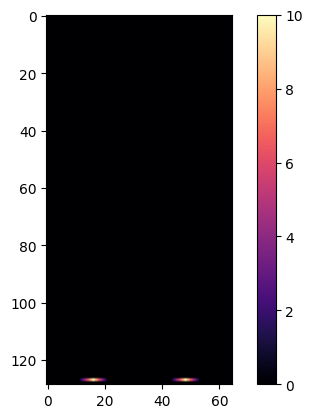

/tmp/ipykernel_324888/2609517846.py:55: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.sum(x, axis=2)), cmap="magma", vmin=0)


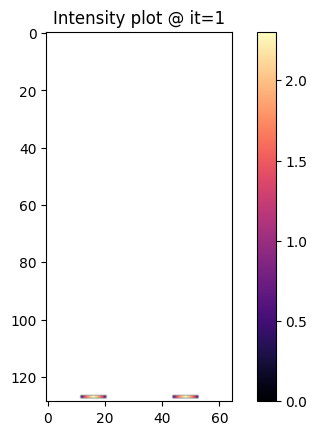

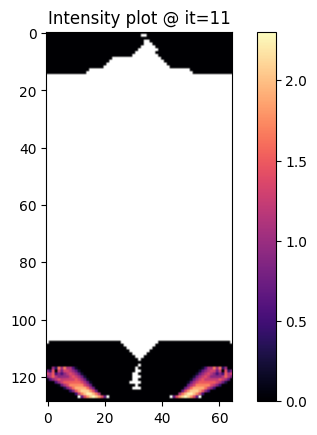

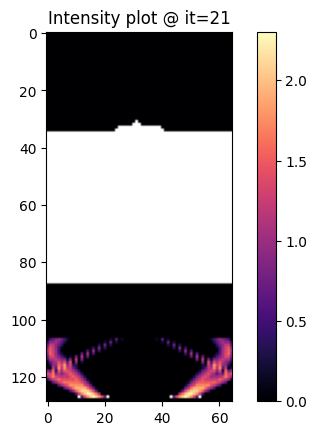

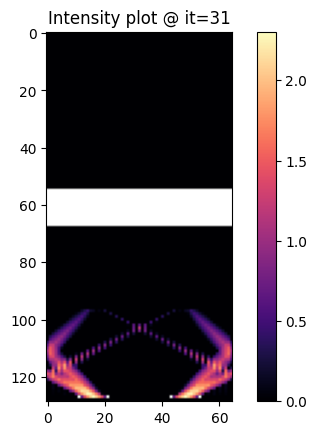

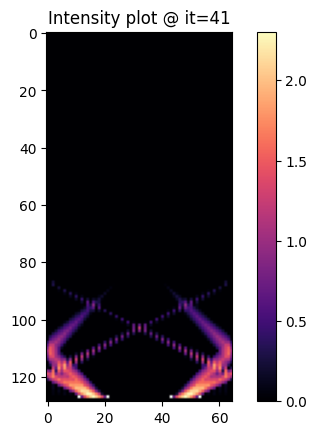

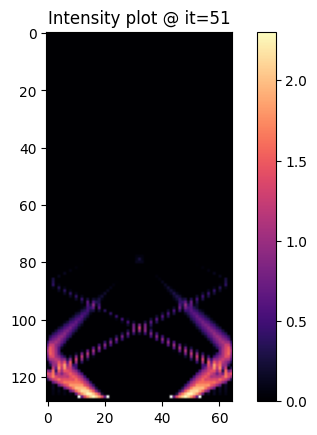

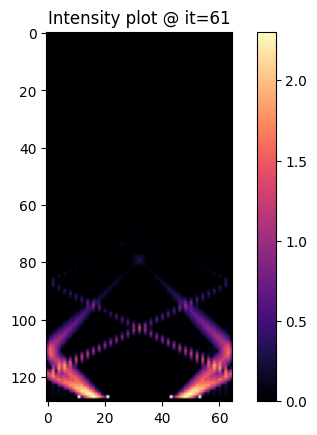

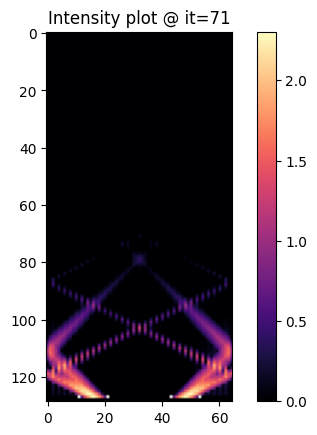

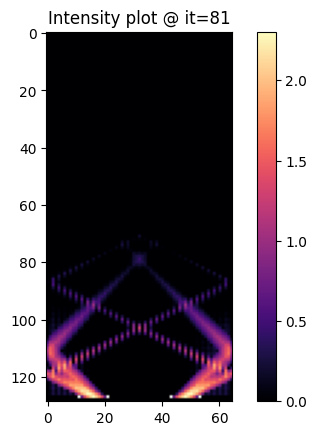

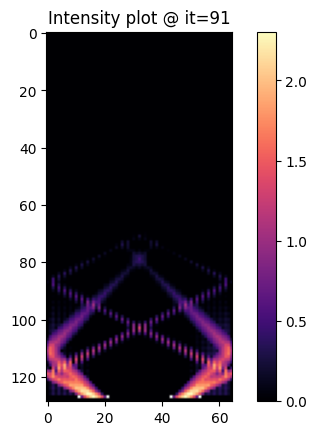

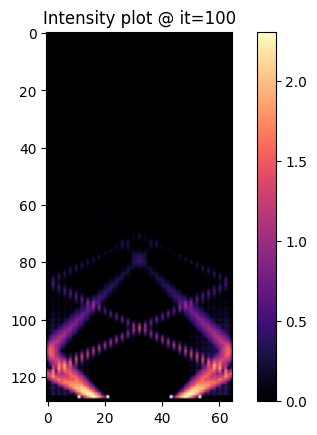

In [33]:
# NX = 31
# NY = 31

NX = 65
# NY = 257
NY = 129

# x0 = None

# nlp = 4
x0 = np.zeros((NY, NX, NL))
# x0[NY//2, NX-2, nlp] = 1

sources = [
    # ((NY//2, NX//2), [1] * 4 + [1] * 4), # D2Q8
    # ((NY//2, NX//2), [1] * 1 + [0] * 7), # D2Q8
    # ((NY//2, NX-1), [1] * 1 + [0] * 7), # D2Q8
    # ((NY//2, NX//2), [1] * 4 + [1] * 4 + [1] * 8) # D2Q16
    # ((NY-2, 3*NX//4), [1 if i in [7,14,15] else 0 for i in range(16)]) # D2Q16
]

if True:
    j = 5
    for k in range(-j, j+1):
        if NL == 8:
            sources.append(((0, 1*NX//4+k), [0]*6 + [j-np.abs(k)]*1 + [0]*1))
            sources.append(((0, 3*NX//4+k), [0]*7 + [j-np.abs(k)]*1 + [0]*0))
        elif NL == 16:
            # sources.append(((NY-1, 1*NX//4+k), [0]*6 + [j-np.abs(k)]*1 + [0]*1 + [0]*8))
            # sources.append(((NY-1, 3*NX//4+k), [0]*7 + [j-np.abs(k)]*1 + [0]*0 + [0]*8))
            
            lattice_vals_l = [0]*NL
            lattice_vals_l[6] = j-np.abs(k)
            lattice_vals_l[12] = j-np.abs(k)
            # lattice_vals_l[13] = j-np.abs(k)
            
            lattice_vals_r = [0]*NL
            lattice_vals_r[7] = j-np.abs(k)
            # lattice_vals_r[14] = j-np.abs(k)
            lattice_vals_r[15] = j-np.abs(k)
            
            sources.append(((NY-2, 1*NX//4+k), lattice_vals_l))
            sources.append(((NY-2, 3*NX//4+k), lattice_vals_r))

x = simulate(
    x0,
    NX, NY,
    sources=sources,
    number_density=0,
    redist_coeff=0.95,
    boundary_conditions="periodic",
    n_it=100,
    plotRealTime=True,
    plotLattViz=False,
    plot_period=0.1
)

In [40]:
from PIL import Image
import os

def pngs_to_gif(folder_path, output_gif, duration=500):
    images = []
    for file in sorted(os.listdir(folder_path)):
        if file.endswith(".png"):
            img_path = os.path.join(folder_path, file)
            images.append(Image.open(img_path).convert("RGBA"))

    if images:
        images[0].save(
            output_gif,
            save_all=True,
            append_images=images[1:],
            duration=duration,
            loop=0
        )
        print(f"GIF saved as {output_gif}")
    else:
        print("No PNG files found in the folder.")

# Example usage
folder = "./lattviz_frames"
output = f"./movies/lattviz.gif"
pngs_to_gif(folder, output, duration=2000)

GIF saved as ./movies/periodic_4edge.gif


In [41]:
# !convert -limit memory 2GiB -loop 0 -layers optimize -resize 1000 -delay 50 './frames/*.png' './frames/output.gif'
!convert -limit memory 2GiB -loop 0 -layers optimize -resize 1000 -delay 50 './lattviz_frames/*.png' './movies/output.gif'

/tmp/ipykernel_19989/4021267980.py:20: RuntimeWarning: divide by zero encountered in log10
  cax = plt.imshow(np.log10(X), cmap="magma")


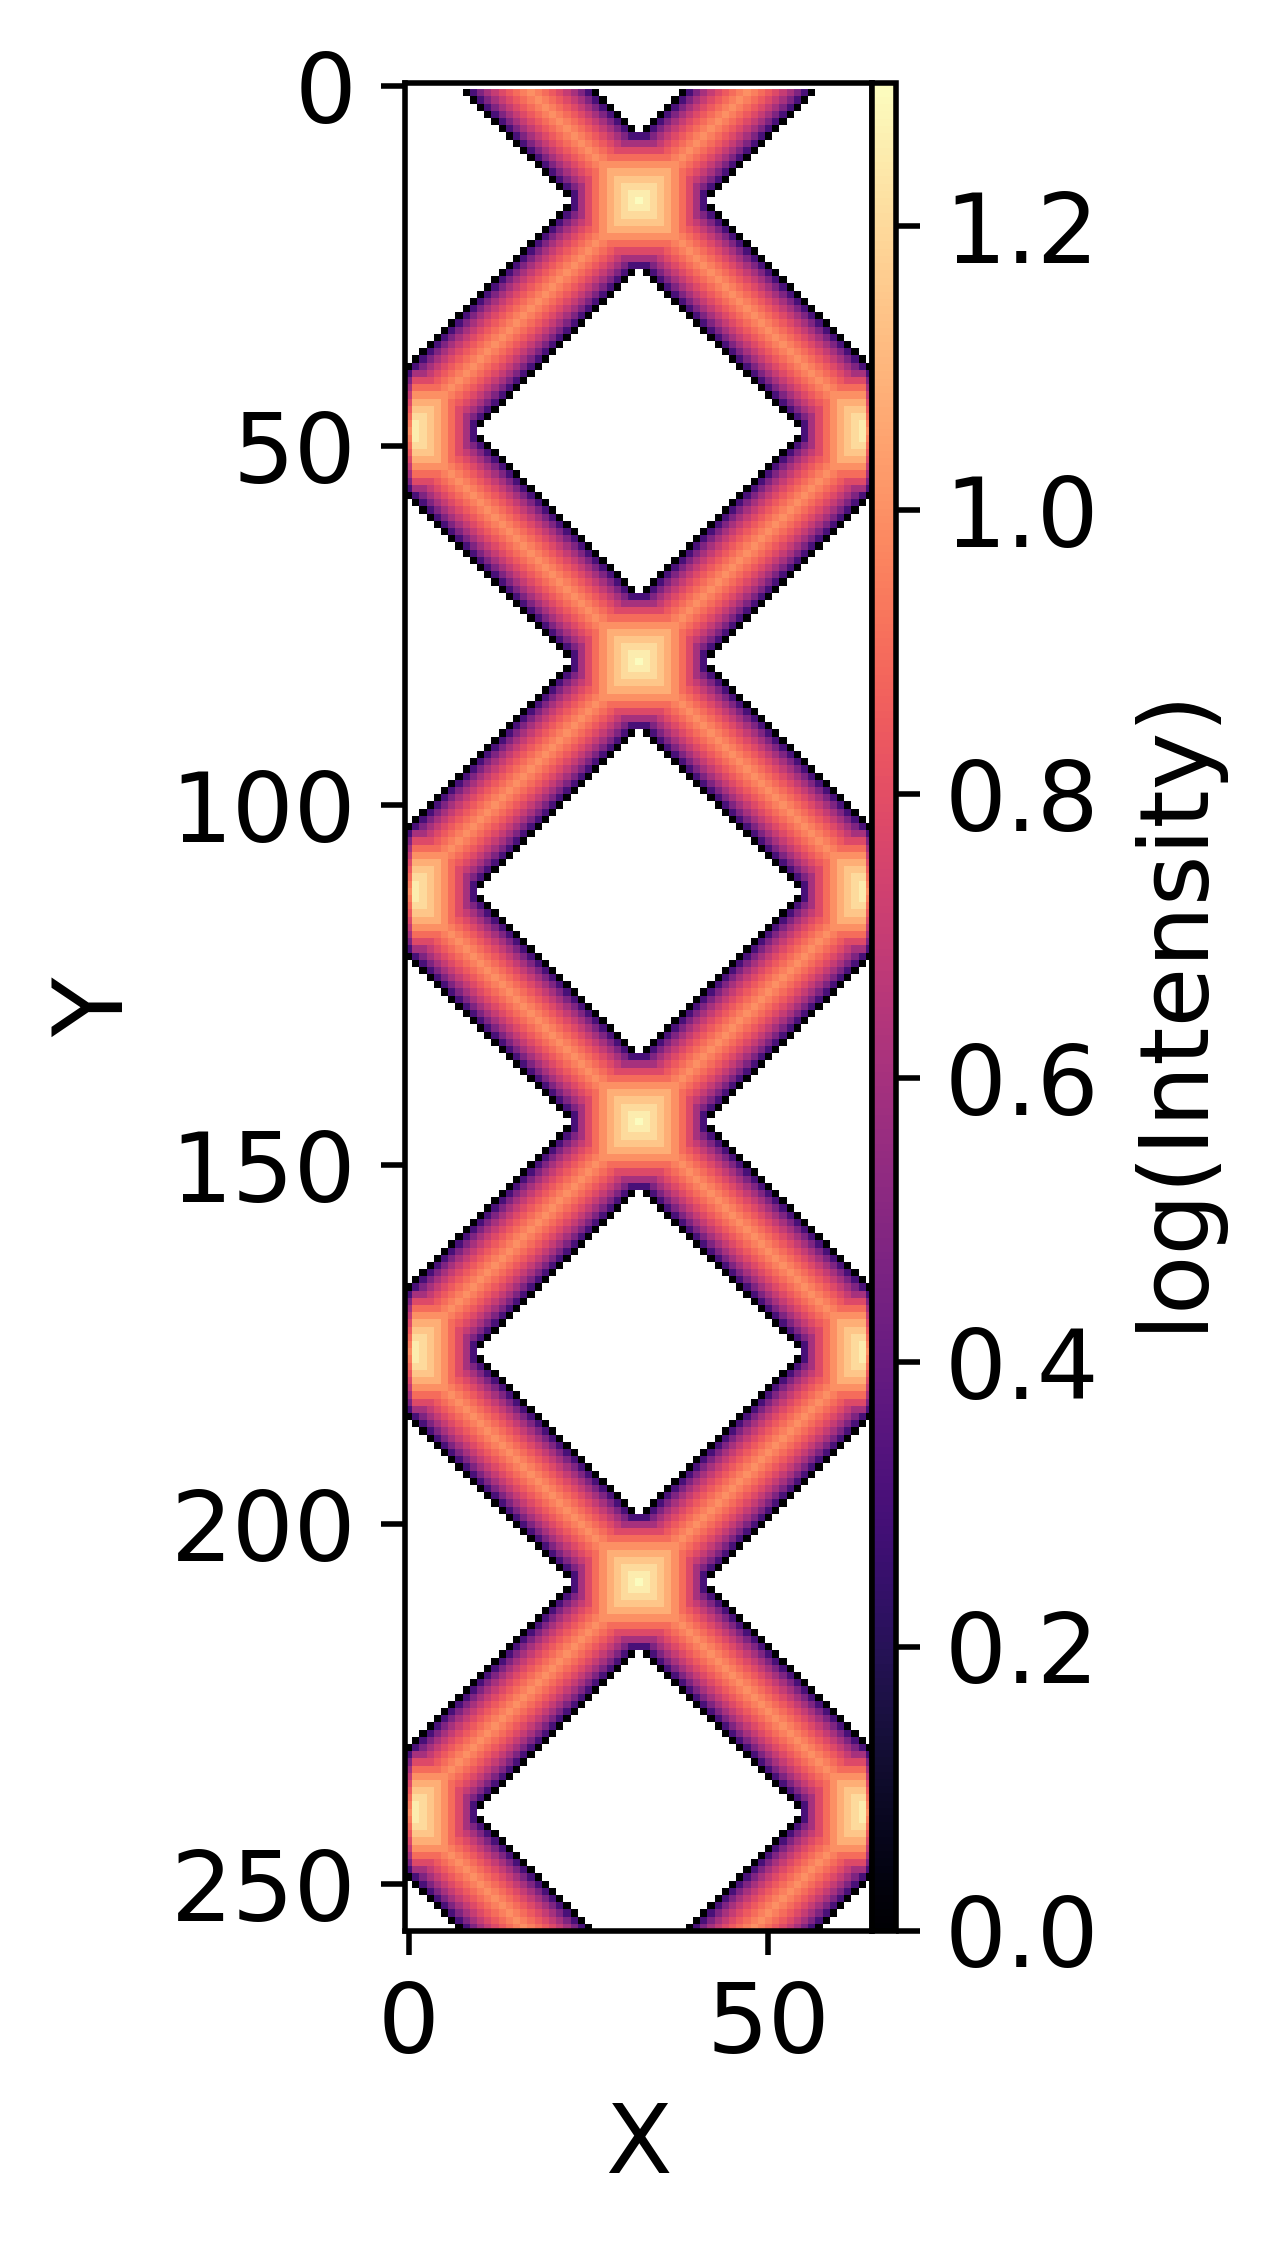

In [47]:
def plot_zoom(scale="normalized"):
    fig, ax = plt.subplots()
    
    X = np.sum(x, axis=2) # full
    
    # X = np.sum(x[:NY//2+1, NX//2:], axis=2) # top-right corner
    # X = np.sum(x[3*N//4:, :N//4], axis=2) # bottom-left corner
    
    # X = np.sum(x[1*NY//4+1:3*NY//4, 1*NX//4+1:3*NX//4], axis=2) # center half
    # X = np.sum(x[3*NY//8:5*NY//8+1, 3*NX//8:5*NX//8+1], axis=2) # center fourth
    # X = np.sum(x[3*NY//8:4*NY//8, 4*NX//8:5*NX//8], axis=2) # center top-left corner
    # X = np.sum(x[3*NY//8:4*NY//8, 4*NX//8:5*NX//8], axis=2) # center top-right corner
    
    # print(X)

    if scale == "normalized":
        cax = plt.imshow(X/np.max(X), cmap="magma")
        label = "Normalized intensity"
    elif scale == "log10":
        cax = plt.imshow(np.log10(X), cmap="magma")
        label = "log(Intensity)"
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    divider = make_axes_locatable(ax)
    cbaxes = divider.append_axes("right", size="5%", pad=0.0)  # Adjust pad to 0 for no gap
    cb = fig.colorbar(cax, cax=cbaxes, label=label)
    
    ax.set_aspect(1)
    plt.gcf().set_dpi(500)
    
    plt.rcParams.update({'font.size': 14})
    
    plt.savefig("crb.png", dpi=500)

plot_zoom("log10")

(10, 10, 8)


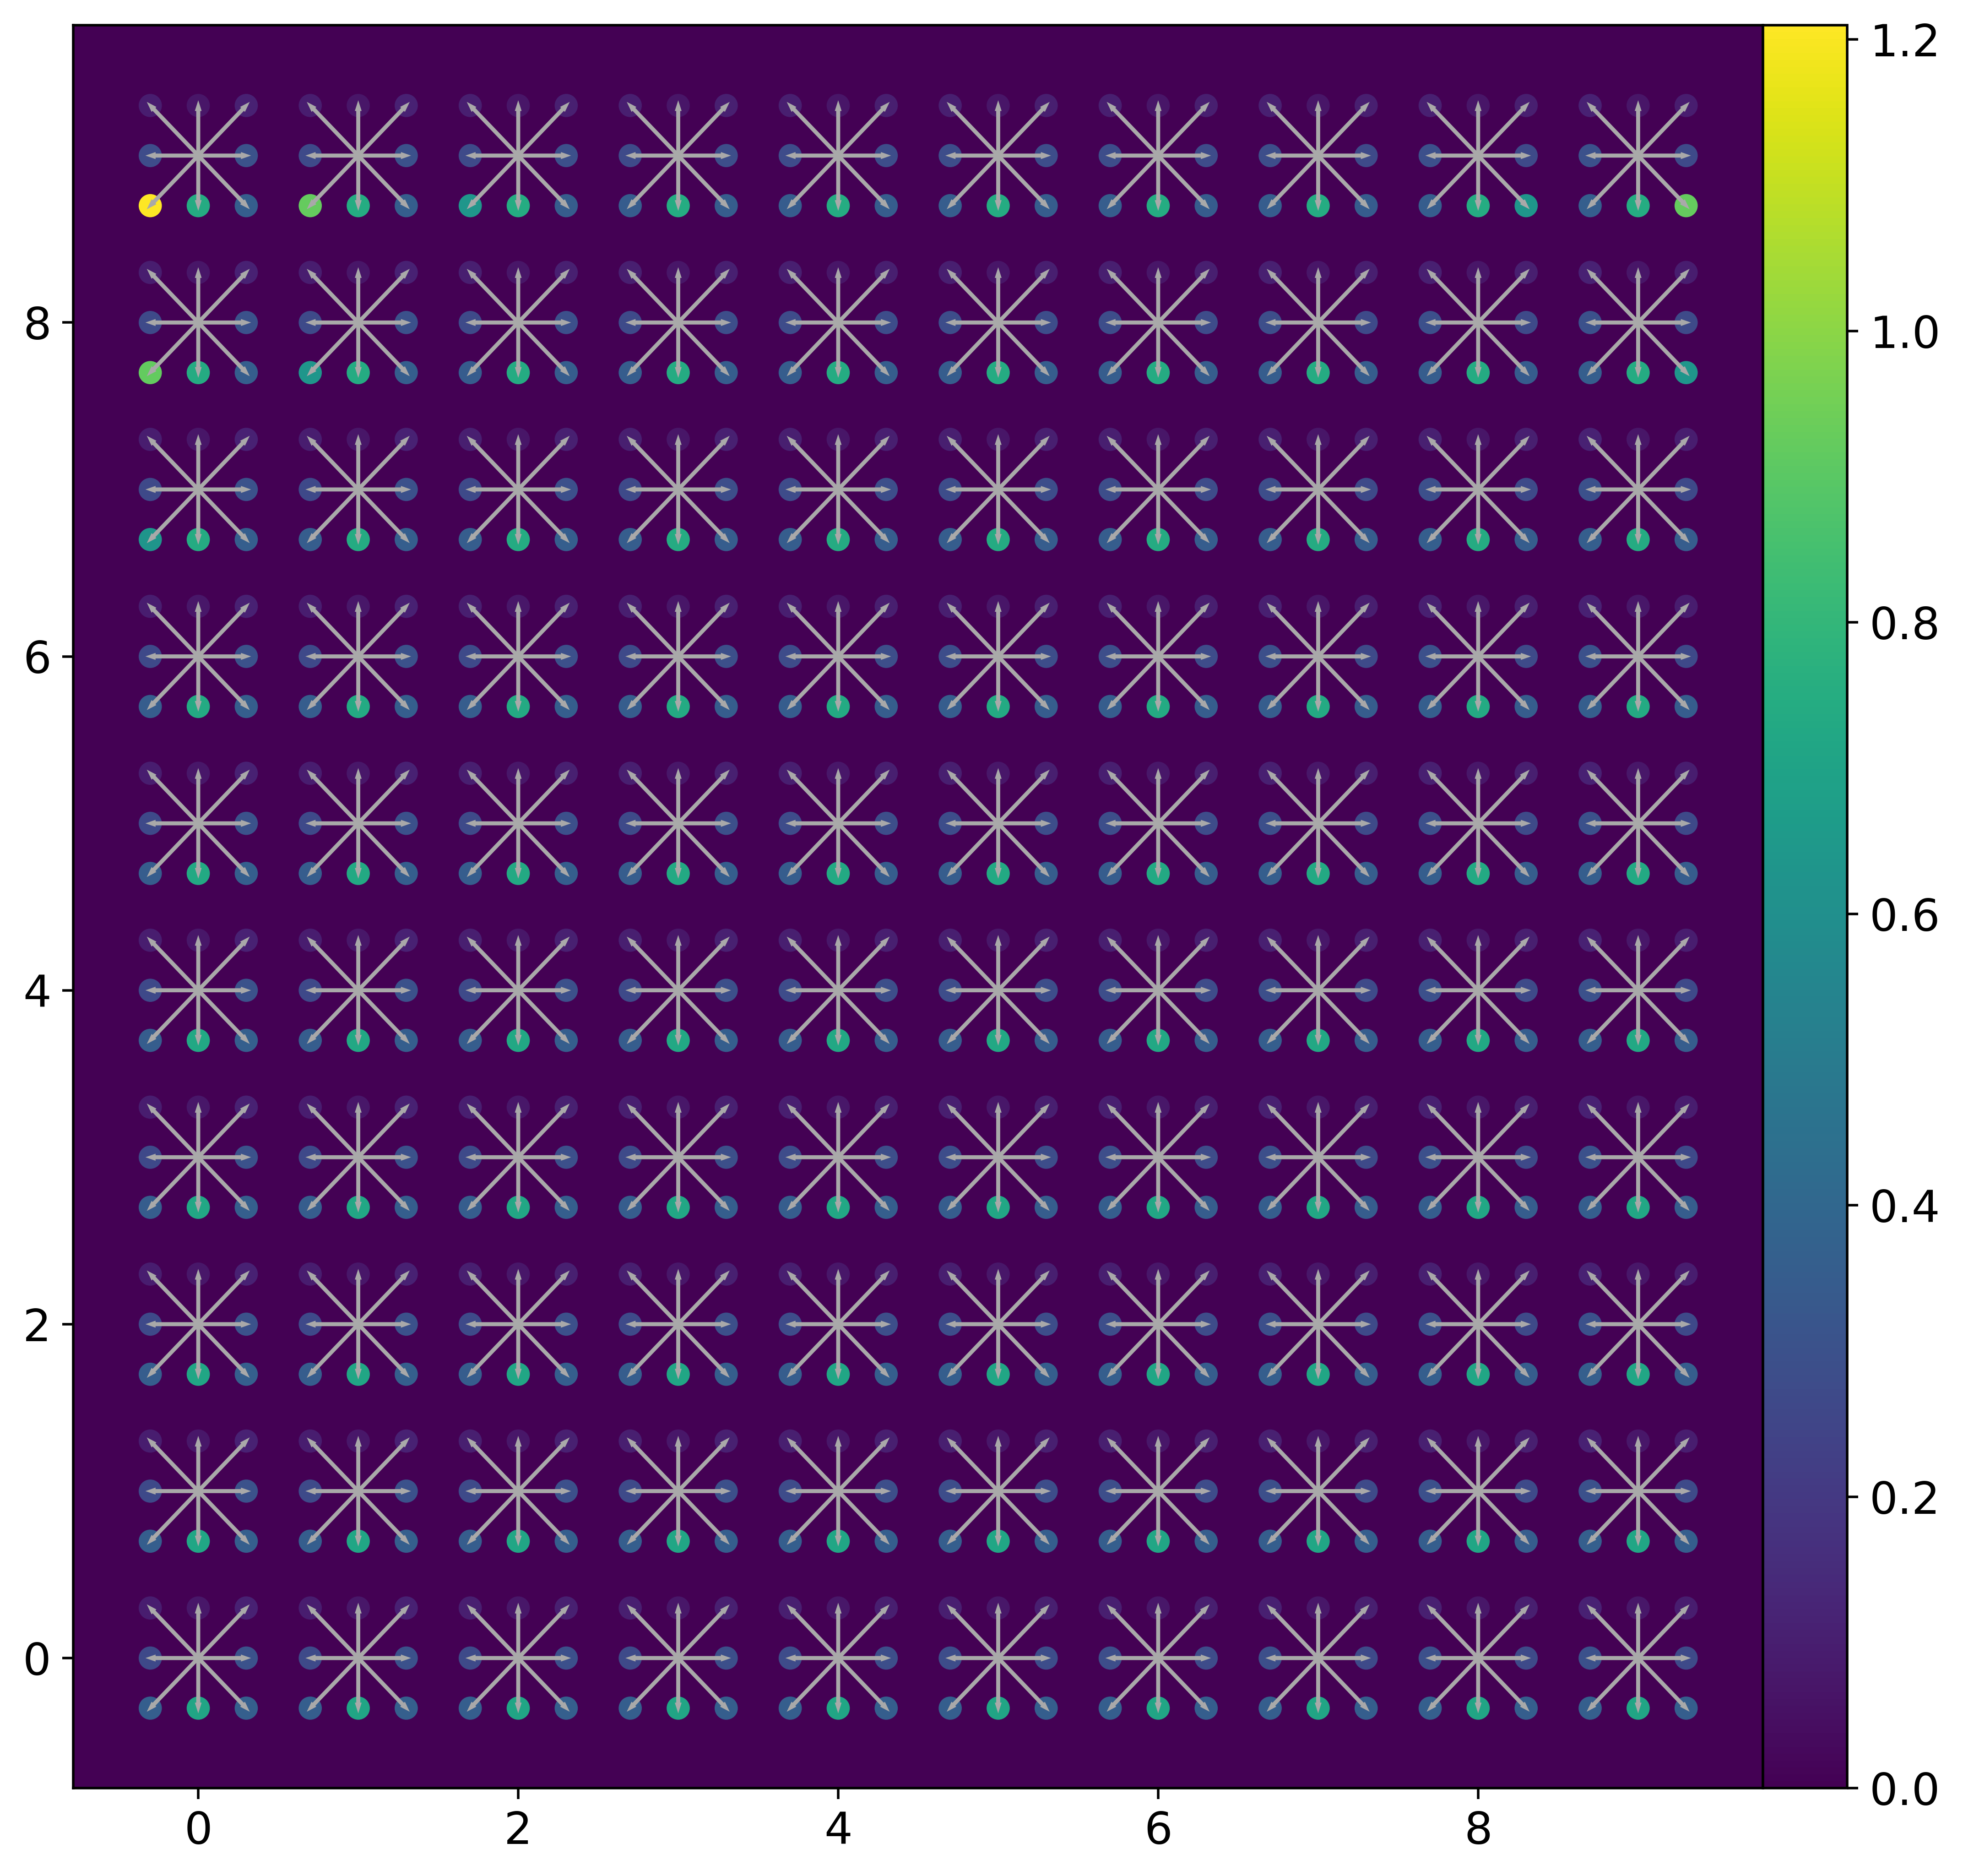

In [23]:
# lattice = x[3*NY//8+1:5*NY//8, 3*NX//8+1:5*NX//8]

Y_c = NY//2
X_c = NX//2
lattice = x[Y_c-5:Y_c+5, X_c-5:X_c+5]

print(lattice.shape)
draw_lattice_2d(lattice, cxs, cys)

In [42]:
np.save("./data/redistribution_data.npy", x)
assert np.allclose(x, np.load("./data/redistribution_data.npy"))

In [43]:
x = np.load("./data/redistribution_data.npy")

(33,)
[-3.27026504  3.15128052]


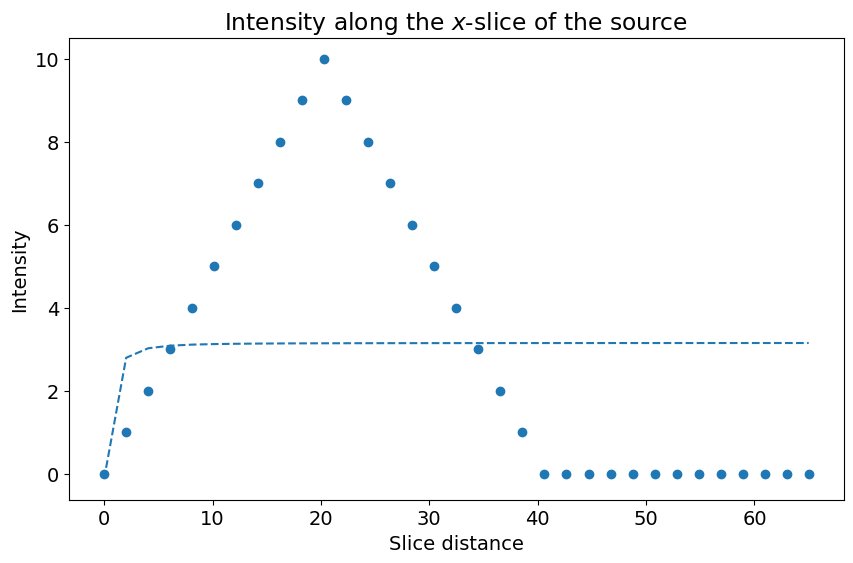

In [44]:
fig, ax = plt.subplots(figsize=(10,6))

# Plot simulation results
intensity_slice = np.sum(x, axis=2)[sources[0][0][1], NX//2:NX]
# intensity_slice = np.flipud(np.sum(x, axis=2)).diagonal()[NX//2:]
print(intensity_slice.shape)

coordinate_slice = np.linspace(0, NX, intensity_slice.size)

plt.scatter(coordinate_slice, intensity_slice)

# Perform fit
i_start = 0
i_stop = len(intensity_slice)

fit_func = inverse_square_bg

fit_params, _ = curve_fit(fit_func, coordinate_slice[i_start:i_stop]+1, intensity_slice[i_start:i_stop])
print(fit_params)

fit_intensity_slice = fit_func(coordinate_slice+1, *fit_params)
plt.plot(coordinate_slice, fit_intensity_slice, "--")

plt.title("Intensity along the $x$-slice of the source")

ax.set_xlabel("Slice distance")
ax.set_ylabel("Intensity")

plt.savefig("./plots/redistribution_slice.png", dpi=500)
plt.show()

In [27]:
# manual 2D radial profile plot
slice_r = []
slice_I = []

hx = sources[0][0][0]
hy = sources[0][0][1]
hz = 0

N = np.sqrt(NX**2 + NY**2 + 0**2)

k = 0 # we select the slice z = 0
for i in range(NX):
    for j in range(NY):
        r = np.sqrt((i-hx)**2 + (hy-j)**2 + (k-hz)**2)
        slice_r.append(r/N)
        slice_I.append(np.sum(x[j, i]))
        
        # print(r, (x, y, z), intensity_slice[x, y].value)

slice_I_norm = slice_I / np.max(slice_I) # normalize intensities - can sometimes help (or hurt) fitting

[-4.30616807  5.61770479]


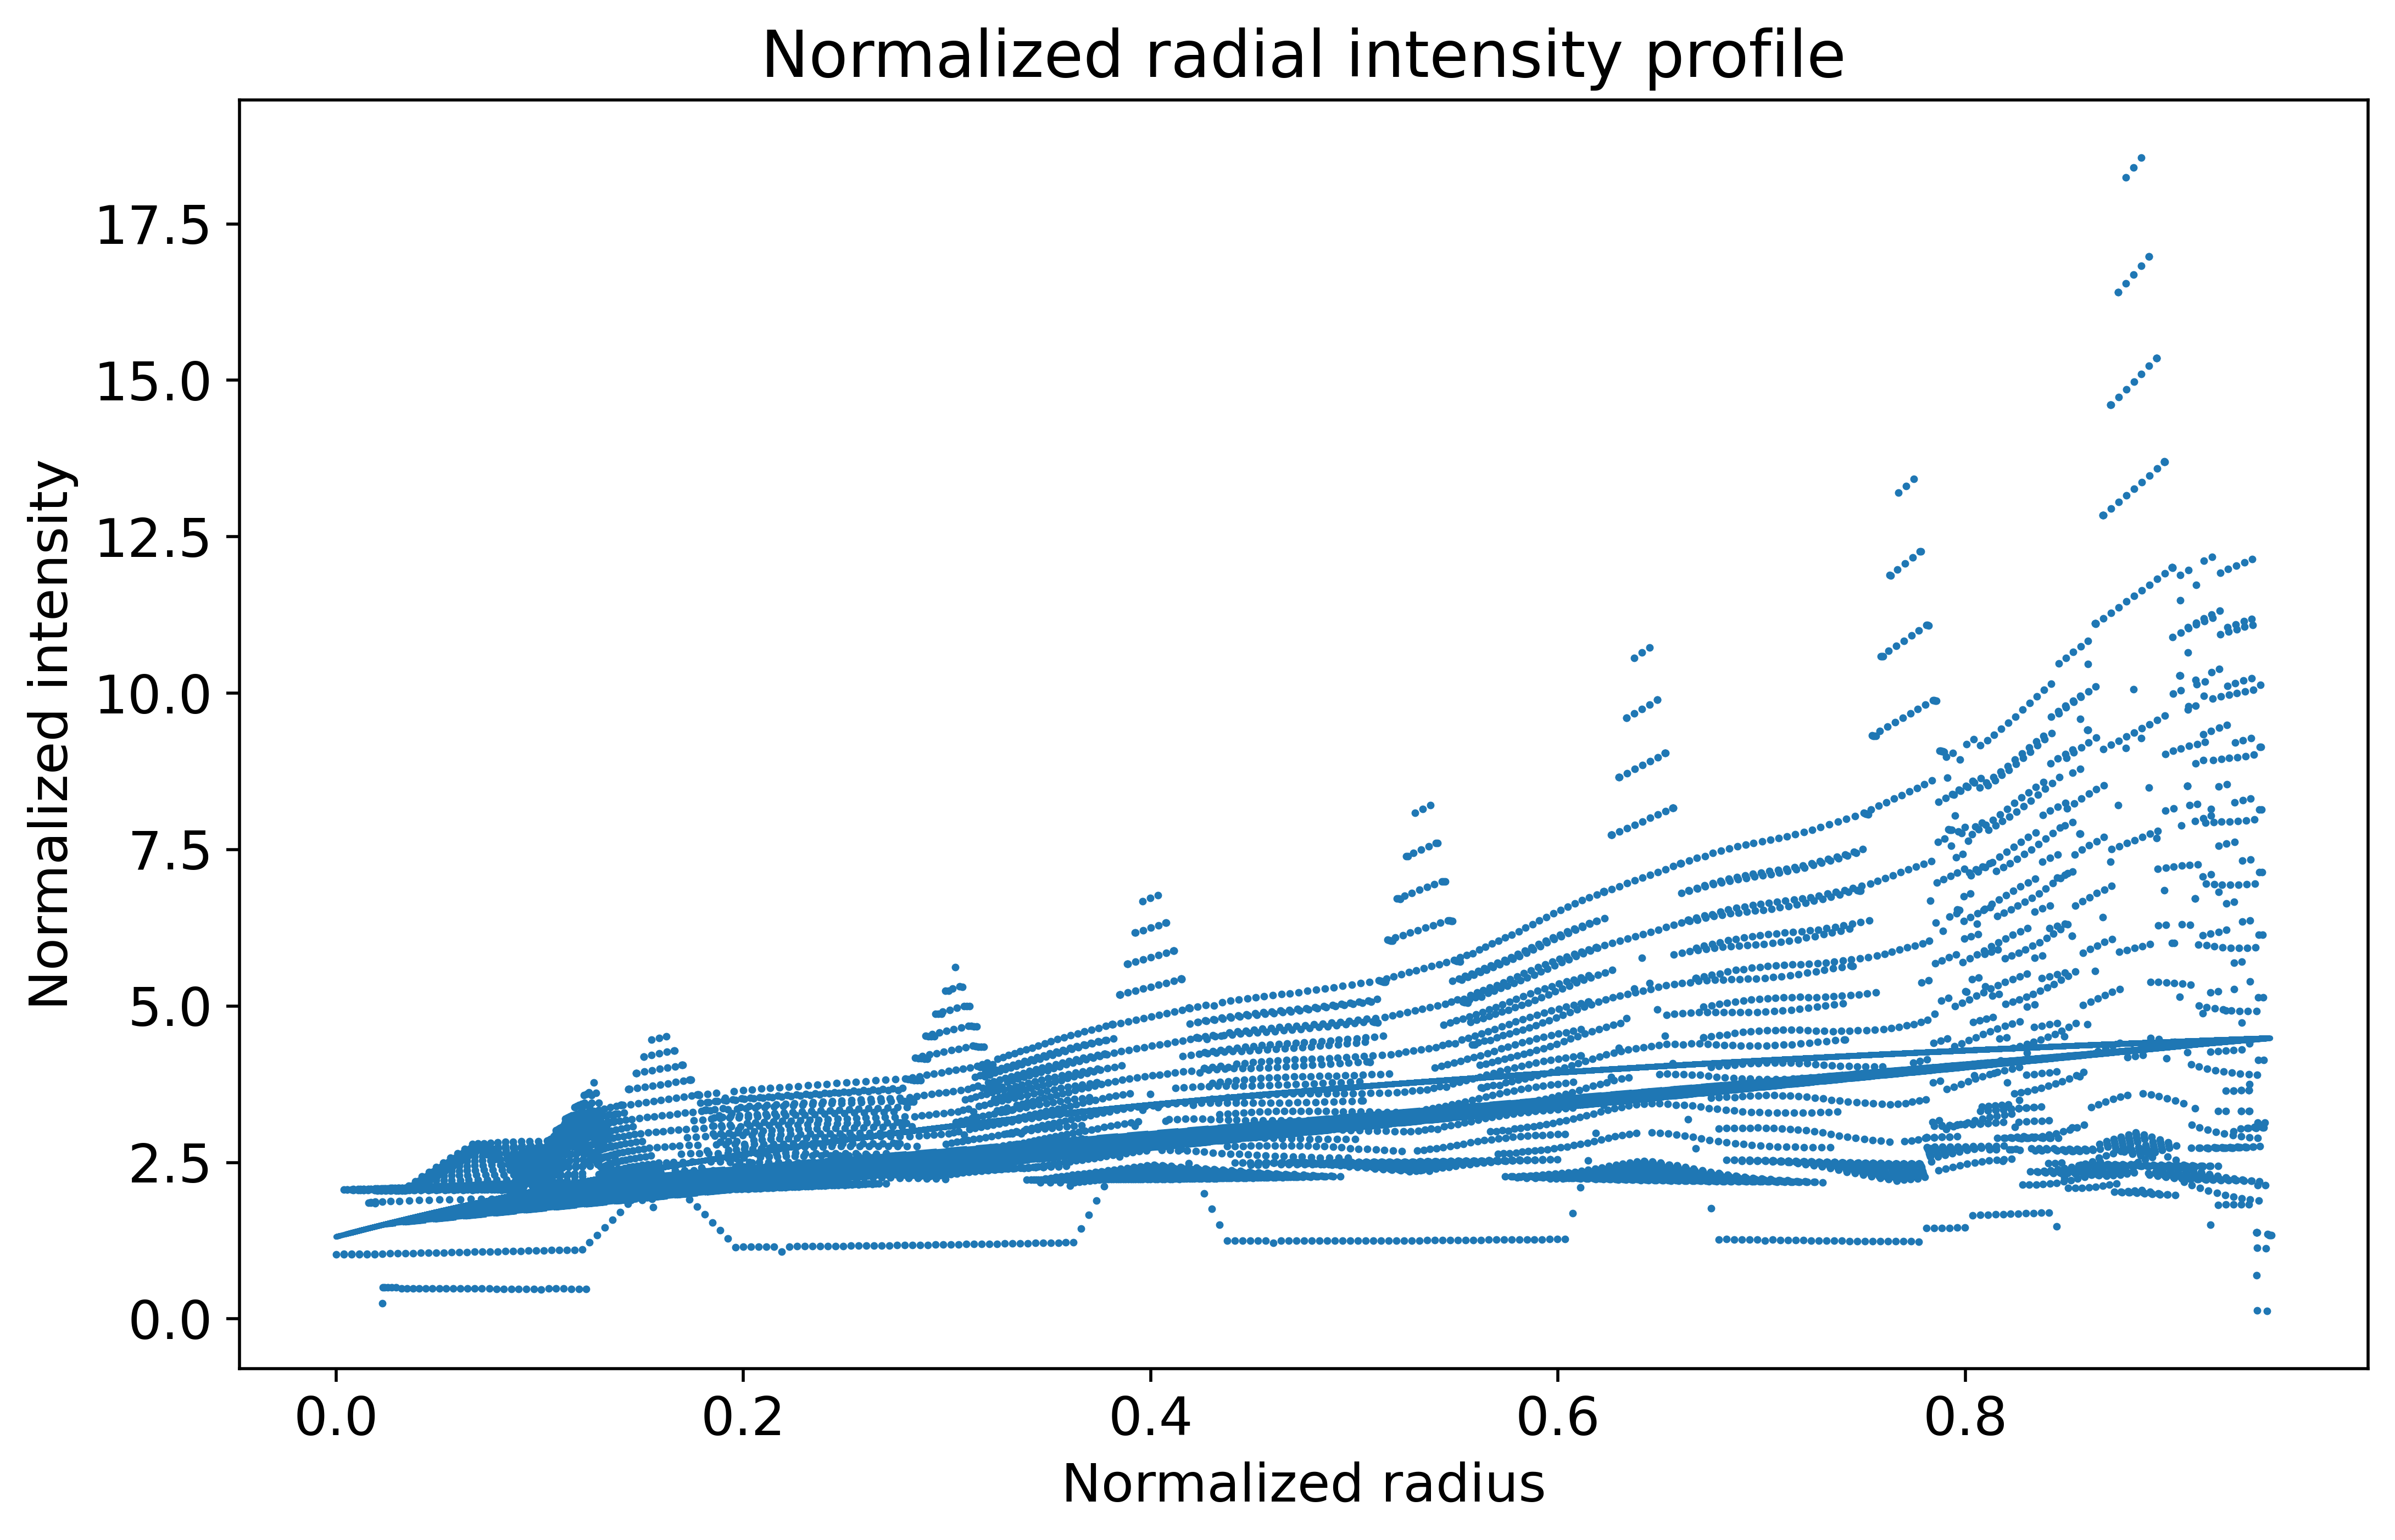

In [28]:
# i_start = 0
i_stop = int(len(slice_r) * 0.5)

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(slice_r[i_start:i_stop], slice_I[i_start:i_stop], s=1)

fit_func = inverse_square_bg

fit_params, _ = curve_fit(fit_func, np.array(slice_r[i_start:i_stop])+1, slice_I[i_start:i_stop])
print(fit_params)

fit_slice_I = fit_func(np.array(slice_r[i_start:i_stop])+1, *fit_params)
# fit_slice_I = fit_func(np.array(slice_r[i_start:i_stop])+1, 2)
plt.plot(slice_r[i_start:i_stop], fit_slice_I[i_start:i_stop], "--")

np.savetxt("./data/normalized_radial_intensities.csv", slice_I, delimiter=",")

plt.title("Normalized radial intensity profile")

ax.set_xlabel("Normalized radius")
ax.set_ylabel("Normalized intensity")

plt.gcf().set_dpi(500)

plt.savefig("./plots/redistribution_radial_profile.png", dpi=1000)
plt.show()

In [29]:
slice_r_groups = {}

for r, I in zip(slice_r, slice_I):
    if r in slice_r_groups:
        slice_r_groups[r].append(I)
    else:
        slice_r_groups[r] = [I]

slice_r_values = []
slice_I_means = []
slice_I_stdevs = []
for r, I_list in slice_r_groups.items():
    slice_r_values.append(r)
    slice_I_means.append(np.mean(I_list))
    slice_I_stdevs.append(np.std(I_list))

slice_I_means = np.array(slice_I_means)
slice_I_stdevs = np.array(slice_I_stdevs)

print(np.shape(slice_r_values), np.shape(slice_I_means), np.shape(slice_I_stdevs))
print(np.std(slice_I), np.mean(slice_I_stdevs))

(11145,) (11145,) (11145,)
1.9965937801706557 0.2125112961974135


In [30]:
# Simultaneously sort both the radii and intensities
z = zip(slice_r_values, slice_I_means)
zs = sorted(z)
u = zip(*zs)
slice_r_values, slice_I_means = map(list, u)
slice_r_values, slice_I_means = np.array(slice_r_values), np.array(slice_I_means)

[3.1086419]


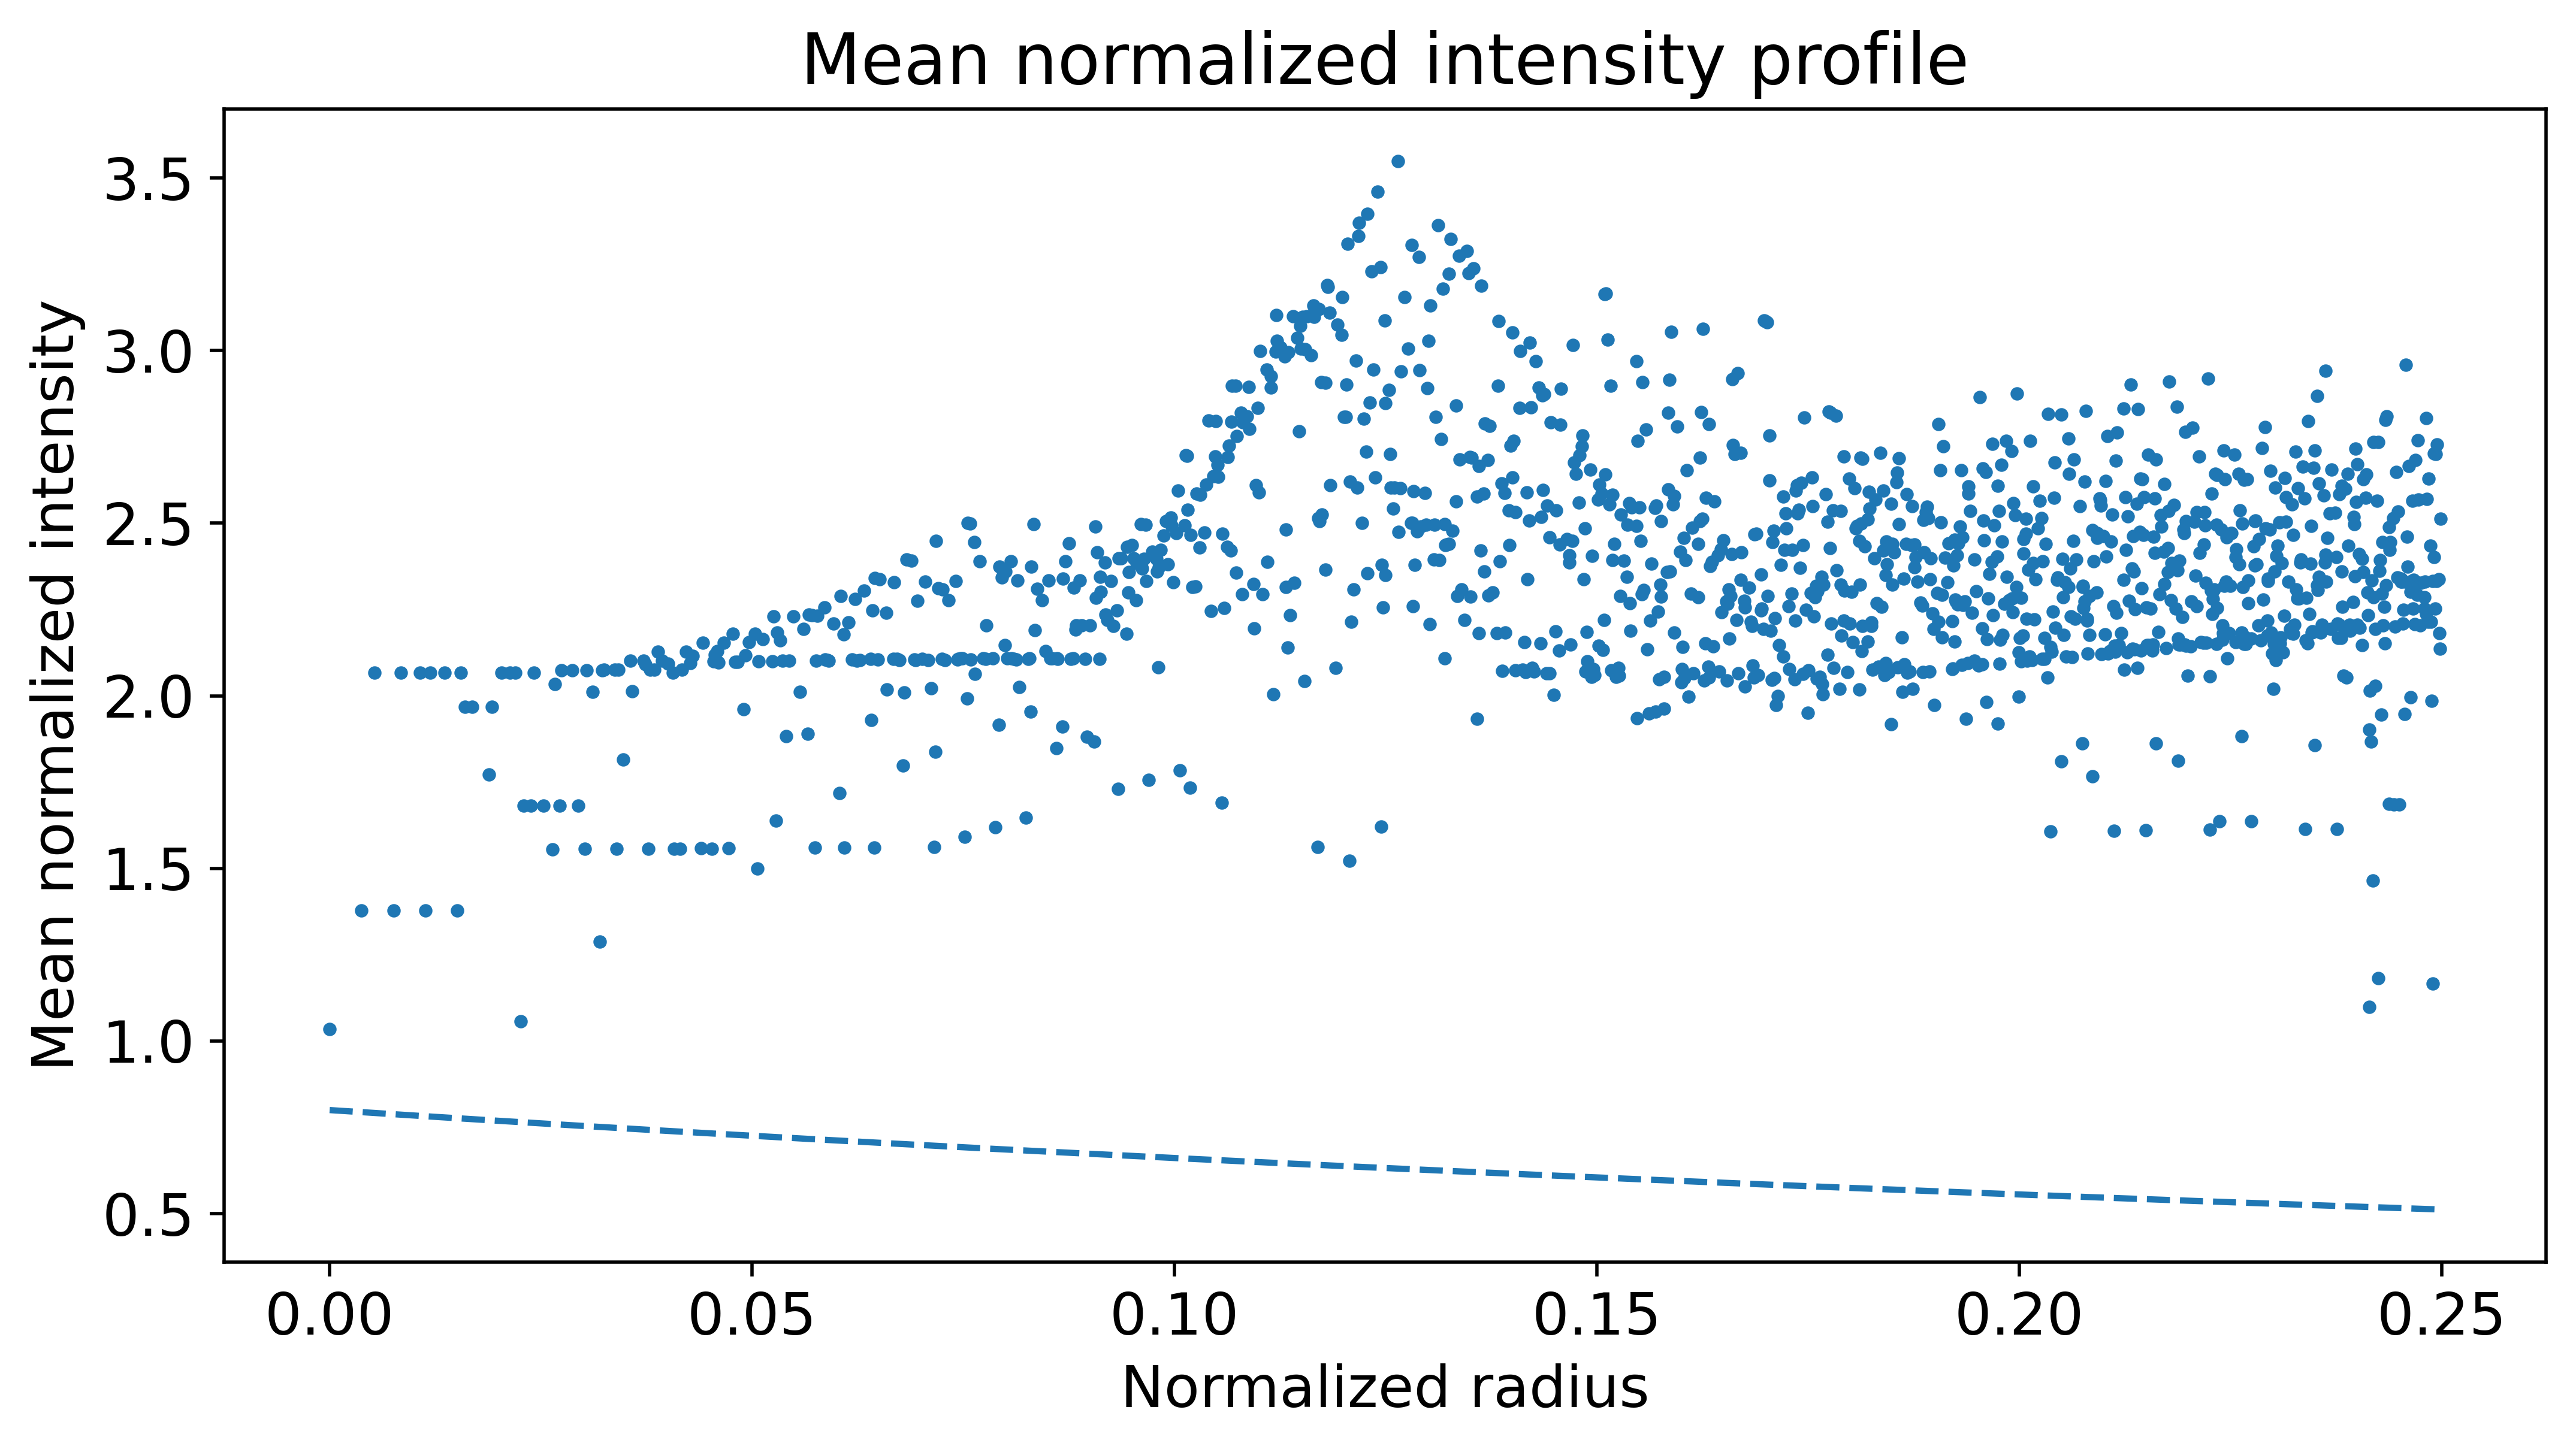

In [31]:
fig, ax = plt.subplots(figsize=(10,5))

x_mask = np.argwhere(slice_r_values <= 0.25)
xlim = np.max(x_mask)
# xlim = np.min(np.argwhere(slice_I_means <= 1E-2))

i_start = 0
i_stop = min(xlim, len(slice_I_means))

plt.scatter(slice_r_values[i_start:i_stop], slice_I_means[i_start:i_stop], s=5)

# Perform fit
fit_func = inverse_square

fit_params, _ = curve_fit(fit_func, slice_r_values[i_start:i_stop]+1, slice_I_means[i_start:i_stop])
print(fit_params)

# fit_intensity_slice = fit_func(slice_r_values+1, *fit_params)
fit_intensity_slice = fit_func(slice_r_values+1, 0.8)
plt.plot(slice_r_values[i_start:i_stop], fit_intensity_slice[i_start:i_stop], "--")

plt.title("Mean normalized intensity profile")

ax.set_xlabel("Normalized radius")
ax.set_ylabel("Mean normalized intensity")

plt.gcf().set_dpi(500)

plt.savefig("./plots/redistribution_mean_radial_profile.png", dpi=1000)
plt.show()

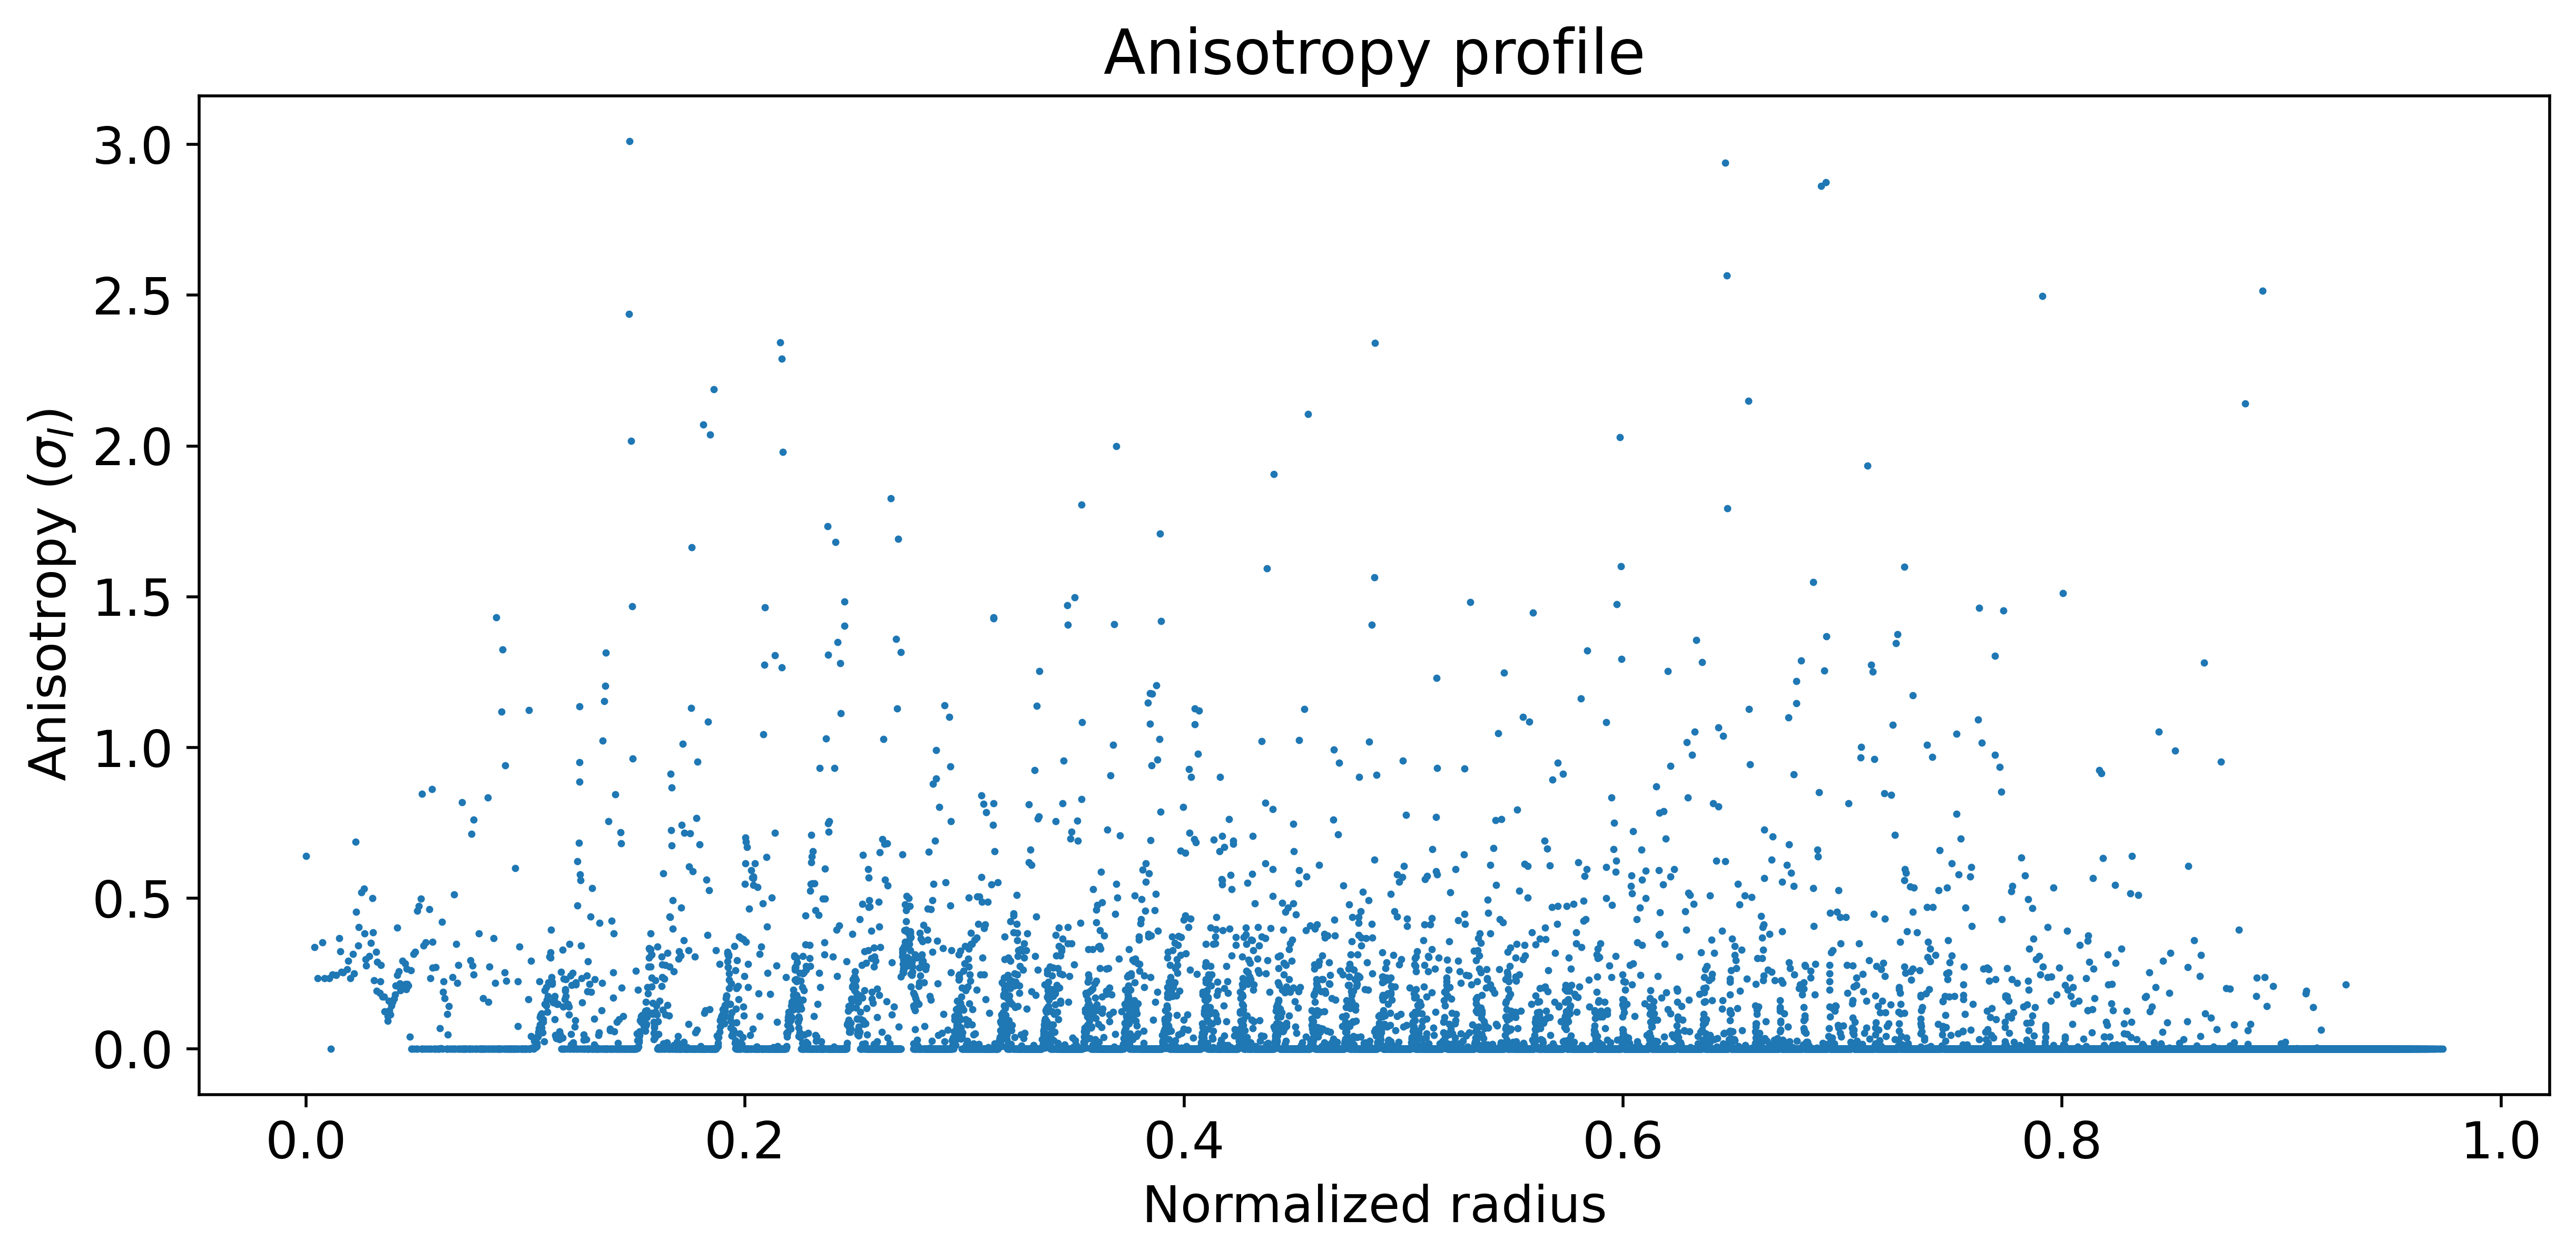

In [32]:
# @TODO - Test other measures of anisotropy (why isn't relative error working?)
fig, ax = plt.subplots(figsize=(10,5))

xlim = int(len(slice_r_values) * 1.0)

# plt.scatter(slice_r_values[:xlim], slice_I_stdevs[:xlim], s=5)
plt.scatter(slice_r_values, slice_I_stdevs/slice_I_means, s=1)

plt.title("Anisotropy profile")

ax.set_xlabel("Normalized radius")
ax.set_ylabel("Anisotropy ($\\sigma_I$)")

plt.gcf().set_dpi(500)
plt.tight_layout()

plt.savefig("./plots/redistribution_anisotropy.png", dpi=1000)
plt.show()